In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd

import data_pre_processing
import dataset_pre_processing
import pre_training
import raw_data_processing
from raw_data_processing import process_PAMAP2_all_data, process_hhar_all_files, process_motion_sense_all_files, open_pickle
import numpy as np
import scipy.stats
import data_pre_processing
import self_har_models
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

tf.get_logger().setLevel('INFO')

# Data pre-processing

In [2]:
# get data from pickle 

with open('pickled_datasets/pamap.pickle', 'rb') as file:
    pamap_df = pickle.load(file)
with open('pickled_datasets/hhar.pickle', 'rb') as file:
    hhar_df = pickle.load(file)
with open('pickled_datasets/motionsense.pickle', 'rb') as file:
    motion_sense_df = pickle.load(file)
    
def concat_datasets(datasets, sensor_type):
    concated_datasets = {}
    ##TODO need to check key to see whether mag exists
    for df in datasets:
        concated_datasets.update(df[sensor_type])
    return concated_datasets

cdf = concat_datasets([pamap_df, hhar_df, motion_sense_df], "acc")
def get_labels(data):
    all_labels = []
    for user in data:
        all_labels = np.concatenate((np.unique(data[user][0][1]), all_labels))
    labels = np.unique(all_labels)
    return labels

labels = get_labels(cdf)
label_map = {label: index for index, label in enumerate(labels)}
print(label_map)
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
    cdf, label_map, 6, 
    ['101', '102', '103', '104', '105', '106', '107', 'a', 'b', 'c', 'd', 'e', 'f', 'g', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'], 
    ["108", "109", "h", "i", "21", "22", "23", "24"], 400, 200
)

{'IMU ankle': 0, 'IMU chest': 1, 'IMU hand': 2, 'Phone': 3, 'Watch': 4, 'iphone': 5}
getting mean
[-0.18597652  1.40292431  4.05411898]
[6.31367612 5.0870368  5.47022979]
normalising train set
normalisnig test


In [5]:
# implement early stopping
callback = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Create a CNN Model

In [4]:
test_model = self_har_models.create_1d_conv_core_model((400,3), "HAR")
cnn_model = self_har_models.attach_full_har_classification_head(test_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
cnn_history = cnn_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=30, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]), callbacks=[callback])

Epoch 1/30
2499/2499 [==============================] - 14s 5ms/step - loss: 0.2002 - categorical_accuracy: 0.9422 - auc: 0.9946 - precision: 0.9475 - recall: 0.9368 - val_loss: 0.1989 - val_categorical_accuracy: 0.9396 - val_auc: 0.9953 - val_precision: 0.9455 - val_recall: 0.9311
Epoch 2/30
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1418 - categorical_accuracy: 0.9595 - auc: 0.9970 - precision: 0.9619 - recall: 0.9570 - val_loss: 0.1405 - val_categorical_accuracy: 0.9635 - val_auc: 0.9976 - val_precision: 0.9663 - val_recall: 0.9618
Epoch 3/30
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1226 - categorical_accuracy: 0.9652 - auc: 0.9976 - precision: 0.9671 - recall: 0.9634 - val_loss: 0.1678 - val_categorical_accuracy: 0.9423 - val_auc: 0.9968 - val_precision: 0.9445 - val_recall: 0.9393
Epoch 4/30
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1145 - categorical_accuracy: 0.9683 - auc: 0.9979 - precision: 0.9697 - 

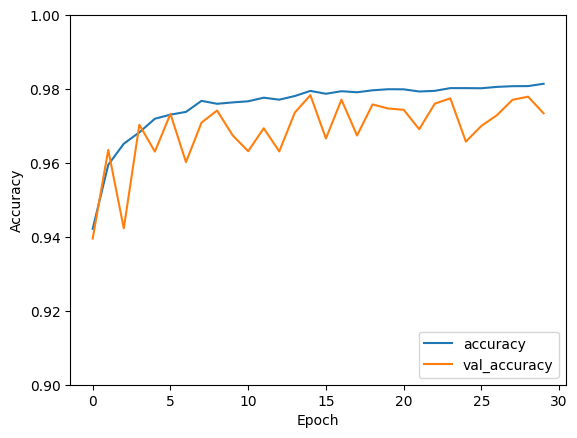

660/660 [==============================] - 1s 2ms/step


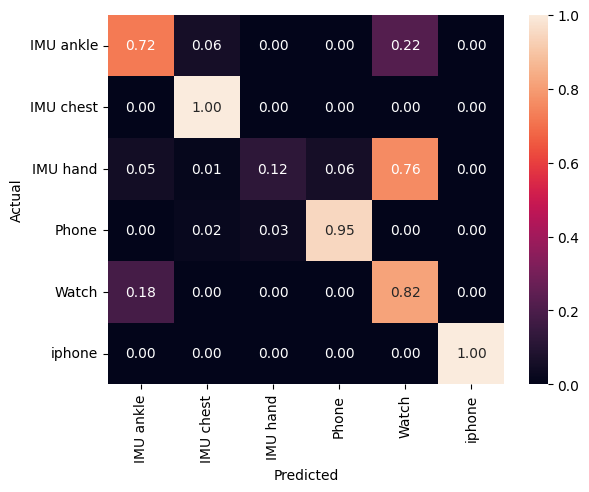

In [5]:
import matplotlib.pyplot as plt
plt.plot(cnn_history.history['categorical_accuracy'], label='accuracy')
plt.plot(cnn_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

cnn_test_result = cnn_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)

predicted_labels = np.argmax(cnn_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Create LSTM-Model

In [ ]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='sigmoid')(x)
LSTM_model = tf.keras.Model(inputs, x, name="LSTM-CNN")
print(LSTM_model.summary())
full_LSTM_model = self_har_models.attach_full_har_classification_head(LSTM_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
LSTM_history = full_LSTM_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=30, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]), callbacks=[callback])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(LSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(LSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_LSTM_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_LSTM_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Dense(300, activation='relu')(x)
x = tf.keras.layers.Conv1D(
        64, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Conv1D(
        128, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Conv1D(
    128, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Conv1D(
    256, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='softmax')(x)

CNNLSTN_model = tf.keras.Model(inputs, x, name="CNN-LSTM")
print(CNNLSTN_model.summary())

In [ ]:
full_CNNLSTM_model = self_har_models.attach_full_har_classification_head(CNNLSTN_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
CNNLSTM_history = full_CNNLSTM_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=30, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]), callbacks=[callback])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(CNNLSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_CNNLSTM_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_CNNLSTM_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Try another CNN-LSTM Model

In [ ]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Dense(300, activation='relu')(x)
x = tf.keras.layers.Conv1D(
        64, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Conv1D(
        128, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Conv1D(
    128, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Conv1D(
    256, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300))(x)
x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='softmax')(x)

CNNLSTN2_model = tf.keras.Model(inputs, x, name="CNN-LSTM")
print(CNNLSTN2_model.summary())

In [ ]:
full_CNNLSTM2_model = self_har_models.attach_full_har_classification_head(CNNLSTN2_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
CNNLSTM2_history = full_CNNLSTM2_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=30, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]), callbacks=[callback])

In [ ]:

plt.plot(CNNLSTM2_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM2_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_CNNLSTM2_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_CNNLSTM2_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# LSTM-CNN Model

In [6]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True, return_state=True))(x)
x = tf.keras.layers.LSTM(300, return_sequences=True)(x)
x = tf.keras.layers.LSTM(300, return_sequences=True)(x)
x = tf.keras.layers.Conv1D(
        32, 24,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv1D(
        64, 16,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv1D(
    96, 8,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.GlobalMaxPool1D(data_format='channels_last', name='global_max_pooling1d')(x) 

LSTMCNN_model = tf.keras.Model(inputs, x, name="LSTM-CNN")
print(LSTMCNN_model.summary())

Model: "LSTM-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 lstm (LSTM)                 (None, 400, 300)          364800    
                                                                 
 lstm_1 (LSTM)               (None, 400, 300)          721200    
                                                                 
 conv1d (Conv1D)             (None, 377, 32)           230432    
                                                                 
 dropout (Dropout)           (None, 377, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 362, 64)           32832     
                                                                 
 dropout_1 (Dropout)         (None, 362, 64)           0  

In [ ]:
full_LSTMCNN_model = self_har_models.attach_full_har_classification_head(LSTMCNN_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
LSTMCNN_history = full_LSTMCNN_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=30, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]), callbacks=[callback])

Epoch 1/30
2499/2499 [==============================] - 122s 47ms/step - loss: 0.2458 - categorical_accuracy: 0.9305 - auc: 0.9925 - precision: 0.9381 - recall: 0.9231 - val_loss: 0.1803 - val_categorical_accuracy: 0.9487 - val_auc: 0.9968 - val_precision: 0.9561 - val_recall: 0.9436
Epoch 2/30
2499/2499 [==============================] - 117s 47ms/step - loss: 0.1641 - categorical_accuracy: 0.9523 - auc: 0.9963 - precision: 0.9555 - recall: 0.9496 - val_loss: 0.1623 - val_categorical_accuracy: 0.9574 - val_auc: 0.9979 - val_precision: 0.9621 - val_recall: 0.9482
Epoch 3/30
2499/2499 [==============================] - 117s 47ms/step - loss: 0.1424 - categorical_accuracy: 0.9588 - auc: 0.9969 - precision: 0.9613 - recall: 0.9568 - val_loss: 0.1606 - val_categorical_accuracy: 0.9590 - val_auc: 0.9971 - val_precision: 0.9660 - val_recall: 0.9520
Epoch 4/30
2499/2499 [==============================] - 117s 47ms/step - loss: 0.1226 - categorical_accuracy: 0.9645 - auc: 0.9977 - precision: 0

In [ ]:
plt.plot(LSTMCNN_history.history['categorical_accuracy'], label='accuracy')
plt.plot(LSTMCNN_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_LSTMCNN_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_LSTMCNN_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)